In [1]:
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'LiH'
geometry = None # [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]
basis = 'sto-6g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='BK')
### HAMILTONIAN end


The LiH ground state under JW is:

$$|\psi \rangle_{HF}^{ground} = | 1 1 1 1 \:  0 0 0 0 0 0 0 0 \rangle$$

and under BK is:

$$|\psi \rangle_{HF}^{ground} = | 1 0 1 0 0 0 0 0 0 0 0 0 \rangle$$

Use NOON to reduces this:

In [2]:
from quchem.Ansatz_Generator_Functions import *

##
NOON_spins_combined, NMO_basis = Hamilt.Get_NOON()
##
Hamilt.Get_CCSD_Amplitudes()

NOON_spins_combined

array([1.99991509e+00, 1.96744892e+00, 2.71958861e-02, 7.94453898e-05,
       2.68032899e-03, 2.68032899e-03])

LOOK at PHYS. REV. X, **8**, 031022 (2018)

Due to NOON:
- indices 0,1 assumed to ALWAYS be filled
- indices 8,9 and 10,11 ALWAYS unfilled! <--- decision



# Therefore Simplify Hamiltonian

In [3]:
ansatz_obj = BK_Qubit_Reduction(QubitHamiltonian,
                             Hamilt.molecule.n_electrons,
                             Hamilt.molecule.n_qubits)

The LiH ground state under JW is:

$$|\psi \rangle_{HF}^{ground} = | 1 1 1 1 \:  0 0 0 0 0 0 0 0 \rangle$$

and under BK is:

$$|\psi \rangle_{HF}^{ground} = | 1 0 1 0 0 0 0 0 0 0 0 0 \rangle$$


we have **fixed occupations** of indices [0,1,8,9,10,11]

- therefore can remove these terms from the Hamiltonian!

In [4]:
list_of_qubit_indices_to_remove = [0,1,8,9,10,11]
reduced_Qubit_Hamiltonian = ansatz_obj.Remove_indices_from_Hamiltonian(list_of_qubit_indices_to_remove)
print('Hamiltonian size reduced: {} --> {}'.format(len(list(QubitHamiltonian)), len(list(reduced_Qubit_Hamiltonian))))

Hamiltonian size reduced: 631 --> 239


In [5]:
qubit_re_label_dict, reduced_RE_LABELLED_Qubit_Hamiltonian = ansatz_obj.Re_label_Hamiltonian(reduced_Qubit_Hamiltonian)
reduced_RE_LABELLED_Qubit_Hamiltonian

(-7.170070919568305+0j) [] +
(-0.01896867446228722+0j) [X0] +
(0.009702964590343796+0j) [X0 X1 X2 X3] +
(-0.0012091978607674074+0j) [X0 X1 X2 Y5] +
(-0.0016354065601825083+0j) [X0 X1 Y2 X3] +
(-0.00020377653620311275+0j) [X0 X1 Y2 Y3 Z4 Z5] +
(0.0012091978607674074+0j) [X0 X1 Y2 Z3 Y5] +
(0.001635406560182508+0j) [X0 X1 Z2 X3] +
(0.00488953965154737+0j) [X0 X1 Z2 Y3 Y4 Z5] +
(-0.0038464821371521625+0j) [X0 X1 Z2 Z3 Y5] +
(-0.002637284276384755+0j) [X0 X1 Z2 Y5] +
(0.004031651676556207+0j) [X0 X1 X4 Y5] +
(-0.00976749332732196+0j) [X0 X1 Z4 Y5] +
(-0.02349046009952933+0j) [X0 X1 Y5] +
(0.0016354065601825083+0j) [X0 Y1 X2 X3] +
(0.00034734865840738377+0j) [X0 Y1 X2 Y3] +
(0.004873629924008761+0j) [X0 Y1 Y2 X3] +
(0.004685763115344257+0j) [X0 Y1 Y2 X3 Z4] +
(-0.005771973313220177+0j) [X0 Y1 Z2 X3] +
(-0.0026924962465502524+0j) [X0 Y1 Y3] +
(-0.00488953965154737+0j) [X0 Y1 Y3 X4] +
(-0.004031651676556207+0j) [X0 Y1 Z3 Y4 X5] +
(-0.005735841650765756+0j) [X0 Y1 Z3 Z4 X5] +
(0.03998383732969

In [17]:
new_Molecular_H_MATRIX = Hamilt.Get_sparse_Qubit_Hamiltonian_matrix(reduced_RE_LABELLED_Qubit_Hamiltonian)


from scipy.sparse.linalg import eigs
eig_values, eig_vectors = eigs(new_Molecular_H_MATRIX)
new_FCI_Energy = min(eig_values)


print('new_FCI = ', new_FCI_Energy, 'VS old FCI:', Hamilt.molecule.fci_energy)

new_FCI =  (-7.828360304777916+5.007235959500277e-17j) VS old FCI: -7.784460280267044


## Looking at Ansatz

In [19]:
# automate:
# reduced_Sec_Quant_CC_ops_ia, reduced_Sec_Quant_CC_ops_ijab, reduced_theta_parameters_ia, reduced_theta_parameters_ijab =ansatz_obj.Remove_NOON_terms(
#     NOON=NOON_spins_combined,
#     occ_threshold= 1.999,
#     unocc_threshold=1e-4,
#     indices_to_remove_list_manual=None, 
#     single_cc_amplitudes=Hamilt.molecule.single_cc_amplitudes,
#     double_cc_amplitudes=Hamilt.molecule.double_cc_amplitudes,
#     singles_hamiltonian=Hamilt.singles_hamiltonian,
#     doubles_hamiltonian=Hamilt.doubles_hamiltonian,
#     tol_filter_small_terms=None)

# manual
reduced_Sec_Quant_CC_ops_ia, reduced_Sec_Quant_CC_ops_ijab, reduced_theta_parameters_ia, reduced_theta_parameters_ijab =ansatz_obj.Remove_NOON_terms(
    NOON=NOON_spins_combined,
    indices_to_remove_list_manual=[0,1,8,9,10,11])

In [20]:
ia_terms, ijab_terms, ia_theta, ijab_theta = ansatz_obj.Get_ia_and_ijab_terms()
print('REDUCTION')
print('ia_terms', len(ia_terms), 'TO', len(reduced_Sec_Quant_CC_ops_ia))
print('ijab_terms', len(ijab_terms), 'TO', len(reduced_Sec_Quant_CC_ops_ijab))

REDUCTION
ia_terms 16 TO 4
ijab_terms 42 TO 3


In [21]:
Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(reduced_Sec_Quant_CC_ops_ia,
                                                                                                                    reduced_Sec_Quant_CC_ops_ijab)

# # NO reduction!
# Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(ia_terms,
#                                                                                                                     ijab_terms)


In [22]:
reduced_CC_ijab = ansatz_obj.Remove_indices_from_CC_qubit_operators(Qubit_Op_list_Second_Quant_CC_Ops_ijab, list_of_qubit_indices_to_remove)
len(reduced_CC_ijab)

3

In [23]:
reduced_RE_LABELLED_CC_ijab = ansatz_obj.Re_label_CC_qubit_operators( qubit_re_label_dict, 
                                                                   reduced_CC_ijab)
reduced_RE_LABELLED_CC_ijab

[0.125j [X0 X1 X2 Y3] +
 0.125j [X0 X1 Y2 X3] +
 -0.125j [X0 Y1 X2 X3] +
 0.125j [X0 Y1 Y2 Y3] +
 -0.125j [Y0 X1 X2 X3] +
 0.125j [Y0 X1 Y2 Y3] +
 -0.125j [Y0 Y1 X2 Y3] +
 -0.125j [Y0 Y1 Y2 X3],
 0.125j [X0 X1 X2 Z3 Z4 Y5] +
 0.125j [X0 X1 Y2 Z3 Z4 X5] +
 -0.125j [X0 Y1 X2 Z3 Z4 X5] +
 0.125j [X0 Y1 Y2 Z3 Z4 Y5] +
 -0.125j [Y0 X1 X2 Z3 Z4 X5] +
 0.125j [Y0 X1 Y2 Z3 Z4 Y5] +
 -0.125j [Y0 Y1 X2 Z3 Z4 Y5] +
 -0.125j [Y0 Y1 Y2 Z3 Z4 X5],
 0.125j [X0 X1 X4 Y5] +
 0.125j [X0 X1 Y4 X5] +
 -0.125j [X0 Y1 X4 X5] +
 0.125j [X0 Y1 Y4 Y5] +
 -0.125j [Y0 X1 X4 X5] +
 0.125j [Y0 X1 Y4 Y5] +
 -0.125j [Y0 Y1 X4 Y5] +
 -0.125j [Y0 Y1 Y4 X5]]

In [24]:
reduced_CC_ia = ansatz_obj.Remove_indices_from_CC_qubit_operators(Qubit_Op_list_Second_Quant_CC_Ops_ia, list_of_qubit_indices_to_remove)

reduced_RE_LABELLED_CC_ia = ansatz_obj.Re_label_CC_qubit_operators( qubit_re_label_dict, 
                                                                   reduced_CC_ia)
reduced_RE_LABELLED_CC_ia

[-0.5j [X0 Z1 Y2] +
 0.5j [Y0 Z1 X2],
 -0.5j [X0 Z1 Z2 Z3 Y4] +
 0.5j [Y0 Z1 Z2 Z3 X4],
 -0.5j [X1 Z2 Y3] +
 0.5j [Y1 Z2 X3],
 -0.5j [X1 Z2 Z3 Z4 Y5] +
 0.5j [Y1 Z2 Z3 Z4 X5]]

## HF input state

In [25]:
print('old input = ', ansatz_obj.Get_BK_HF_state_in_OCC_basis())

print('BUT following indices removed:', list_of_qubit_indices_to_remove)

ansatz_obj.New_BK_HF_state(list_of_qubit_indices_to_remove)

old input =  [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
BUT following indices removed: [0, 1, 8, 9, 10, 11]


array([1., 0., 0., 0., 0., 0.])

# Ansatz

look at: From PHYS. REV. X, **8**, 031022 (2018)

can make a further reduction!

In [28]:
N_QUBITS = Hamilt.molecule.n_qubits - len(list_of_qubit_indices_to_remove)
# or len(ansatz_obj.New_BK_HF_state(list_of_qubit_indices_to_remove))

N_electrons = int(sum(ansatz_obj.New_BK_HF_state(list_of_qubit_indices_to_remove)))

full_ansatz_Q_Circ = Ansatz_Circuit(reduced_RE_LABELLED_CC_ia, reduced_RE_LABELLED_CC_ijab,
             N_QUBITS, N_electrons, manual_HF_state=ansatz_obj.New_BK_HF_state(list_of_qubit_indices_to_remove))

ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(reduced_theta_parameters_ia, 
                                                              reduced_theta_parameters_ijab,
                                                              transformation='BK')

print(ansatz_cirq_circuit.to_text_diagram(transpose=True)) 

0         1         2         3         4         5
│         │         │         │         │         │
X         │         H         │         H         H
│         │         │         │         │         │
Rx(0.5π)  │         │         │         │         │
│         │         │         │         │         │
@─────────X         │         │         │         │
│         │         │         │         │         │
│         @─────────X         │         │         │
│         │         │         │         │         │
│         │         Rz(-0.0π) │         │         │
│         │         │         │         │         │
│         @─────────X         │         │         │
│         │         │         │         │         │
@─────────X         H         │         │         │
│         │         │         │         │         │
Rx(-0.5π) │         Rx(0.5π)  │         │         │
│         │         │         │         │         │
H         │         │         │         │         │
│         │ 

# Running Example

In [29]:
from quchem.Simulating_Quantum_Circuit import *

In [30]:
n_shots= 100


def VQE_experiment_ENERGY(theta_ia_ijab_list):
    
    theta_ia = theta_ia_ijab_list[0:len(reduced_theta_parameters_ia)]
    theta_ijab = theta_ia_ijab_list[len(reduced_theta_parameters_ijab)::]
    
    ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_ia, 
                                                              theta_ijab,
                                                              transformation='BK')
    
    VQE_exp = VQE_Experiment(reduced_RE_LABELLED_Qubit_Hamiltonian, ansatz_cirq_circuit, n_shots)
    return VQE_exp.Calc_Energy().real

In [46]:
import random

theta_ia_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(reduced_theta_parameters_ia))]
theta_ijab_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(reduced_theta_parameters_ijab))]

theta_combined_random_input = [*theta_ia_random_input, *theta_ijab_random_input]

VQE_experiment_ENERGY(theta_combined_random_input)

-7.541858812600689

In [18]:
Hamilt.molecule.fci_energy

array(-7.78446028)

# Using measurement reduction!

In [32]:
from quchem.LCU_method import *

In [33]:
Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(reduced_RE_LABELLED_Qubit_Hamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)
anti_commuting_sets

Building Graph Edges: 100%|##########| 239/239 [00:02<00:00, 100.21it/s]


{0: [(0.07823637778985244+0j) [Z1 Z3 Z5]],
 1: [(-7.170070919568305+0j) []],
 2: [(-0.14453638564662347+0j) [Z4],
  (0.0055775651340550965+0j) [Y4],
  (0.010522977441818161+0j) [Z1 Z3 X4 Z5]],
 3: [(-0.14453638564662347+0j) [Z1 Z3 Z4 Z5],
  (0.0055775651340550965+0j) [Z1 Z3 Y4 Z5],
  (0.010522977441818161+0j) [X4]],
 4: [(0.033722569214841416+0j) [Z0],
  (0.05493833181411909+0j) [Y0],
  (-0.01896867446228722+0j) [X0]],
 5: [(-0.13300290386455665+0j) [Z2 Z3],
  (0.004873629924008756+0j) [X1 Z2 X3],
  (0.012458849604517958+0j) [Y2],
  (0.02218840259886891+0j) [X2],
  (-0.002562389780011484+0j) [X1 Z2 Y3 X4 Z5],
  (0.03357448433055081+0j) [Z1 Z2 X3 Y5],
  (-0.002562389780011484+0j) [X1 Z2 Y3 Y4 Z5],
  (0.0010954854746108708+0j) [Y1 Z2 X3 Z4]],
 6: [(-0.1330029038645566+0j) [Z2],
  (0.012458849604517958+0j) [Y2 Z3],
  (0.005771973313220177+0j) [X1 Y2 X3],
  (0.004873629924008761+0j) [X0 Y1 Y2 X3],
  (-0.002950384991514586+0j) [Z1 Y2 X3 Y5],
  (0.00488953965154737+0j) [Z0 X1 Y2 Y3 X4 Z5],
 

In [34]:
N_QUBITS = Hamilt.molecule.n_qubits - len(list_of_qubit_indices_to_remove)
n_shots= 100


full_ansatz_Q_Circ = Ansatz_Circuit(reduced_RE_LABELLED_CC_ia, reduced_RE_LABELLED_CC_ijab,
         N_QUBITS, N_electrons, manual_HF_state=ansatz_obj.New_BK_HF_state(list_of_qubit_indices_to_remove))

def GIVE_ENERGY_LCU(theta_ia_theta_jab_list):
    theta_ia = theta_ia_theta_jab_list[:len(reduced_theta_parameters_ia)]
    theta_ijab = theta_ia_theta_jab_list[len(reduced_theta_parameters_ijab):]
    
    ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_ia, 
                                                              theta_ijab,
                                                              transformation='BK')

    VQE_exp_LCU =  VQE_Experiment_LCU_UP(anti_commuting_sets,
                     ansatz_cirq_circuit,
                     n_shots,
                     N_QUBITS,
                     N_indices_dict=None)#{7:0, 8:1, 9:0, 10:1})
    
    return VQE_exp_LCU.Calc_Energy().real


In [47]:
GIVE_ENERGY_LCU(theta_combined_random_input)

-7.373774146501257

# Optimization

In [36]:
def calc_gradient_ADAM(theta_ia_theta_jab_list):
    
    grad_list=[]
    
    for index, theta in enumerate(theta_ia_theta_jab_list):
        
        new_theta_list = theta_ia_theta_jab_list.copy()
        new_theta_list[index] = theta + np.pi/4
        
        Obs_PLUS = GIVE_ENERGY_LCU(new_theta_list)
               
        
        new_theta_list[index] = theta - np.pi/4
        Obs_MINUS = GIVE_ENERGY_LCU(new_theta_list)
        
        gradient = Obs_PLUS - Obs_MINUS
        
        grad_list.append(gradient)
        

    return np.array(grad_list)

In [41]:
### optimizer
from quchem.Scipy_Optimizer import _minimize_Adam, NEW_Optimizer

In [48]:
custom_optimizer_DICT = {'learning_rate': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                           'delta': 1e-8, 'maxfev': 15000}

GG = NEW_Optimizer(GIVE_ENERGY_LCU,
                   theta_combined_random_input,
                   args=(),
                   method=_minimize_Adam,
                   jac=calc_gradient_ADAM,
                   hess=None,
                   hessp=None,
                      bounds=None,
                   constraints=None,
                   tol=1e-20, 
                   display_convergence_message=True,
                   display_steps=True, 
                   custom_optimizer_DICT=custom_optimizer_DICT)
GG.get_env(100)
GG.plot_convergence()
plt.show()

0: Input_to_Funct: [2.98314652 0.32803246 4.25948619 5.27046437 5.97827179 5.48929106
 6.01918168]: Output: -7.524638416236773
1: Input_to_Funct: [3.0742443  0.22975002 4.31784172 5.19061079 5.93946043 5.47417201
 6.116209  ]: Output: -7.5101811939418806
2: Input_to_Funct: [3.12804043 0.13354337 4.36562063 5.12317151 5.87209027 5.50152211
 6.21102818]: Output: -7.663037488184454
3: Input_to_Funct: [3.15791528 0.03949633 4.43464149 5.04629127 5.80821283 5.50333719
 6.26780123]: Output: -7.675210247294184
4: Input_to_Funct: [ 3.18769694 -0.05331455  4.51311885  4.96169371  5.76429925  5.47080094
  6.33513972]: Output: -7.639460214419575
5: Input_to_Funct: [ 3.1706777  -0.13831238  4.58295475  4.88078595  5.7231342   5.4265458
  6.39073114]: Output: -7.622640729175951
6: Input_to_Funct: [ 3.14693965 -0.20018341  4.59328956  4.79448046  5.68768361  5.39028907
  6.45029525]: Output: -7.571949448706456
7: Input_to_Funct: [ 3.11302752 -0.242716    4.6241739   4.72054079  5.64887156  5.3446844

61: Input_to_Funct: [ 3.17285962 -0.09287411  5.89649669  4.70095074  5.65353893  4.06086538
  6.95555345]: Output: -7.673182618695008
62: Input_to_Funct: [ 3.15909275 -0.09019006  5.87366625  4.68924011  5.64883068  4.00937539
  6.96015913]: Output: -7.6689130789956375
63: Input_to_Funct: [ 3.13959413 -0.08741922  5.84281756  4.6691544   5.64654229  3.98336263
  6.96629348]: Output: -7.644713551344161
64: Input_to_Funct: [ 3.1277881  -0.08505536  5.81687979  4.63956067  5.65005617  3.96203937
  6.97612101]: Output: -7.655602726772727
65: Input_to_Funct: [ 3.11279348 -0.08200278  5.79491268  4.59258036  5.65355601  3.95725803
  6.99114376]: Output: -7.6889037168657834
66: Input_to_Funct: [ 3.10869899 -0.0844222   5.77709531  4.53334093  5.67728864  3.94394629
  7.02111553]: Output: -7.6336209915798445
67: Input_to_Funct: [ 3.11207376 -0.08295498  5.78000071  4.50006206  5.69778359  3.93533754
  7.03572073]: Output: -7.685467742350967
68: Input_to_Funct: [ 3.12822971 -0.09493312  5.7807

AttributeError: 'NEW_Optimizer' object has no attribute 'store_values'

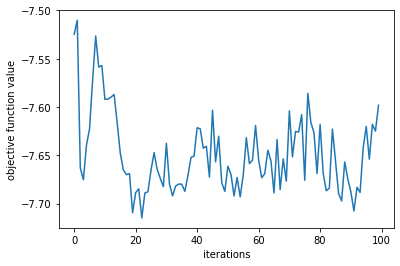

In [31]:
from quchem.Adam_Optimizer import *

def calc_gradient_ADAM(theta_ia_theta_jab_list):
    
    grad_list=[]
    
    for index, theta in enumerate(theta_ia_theta_jab_list):
        
        new_theta_list = theta_ia_theta_jab_list.copy()
        new_theta_list[index] = theta + np.pi/4
        
        Obs_PLUS = GIVE_ENERGY_LCU(new_theta_list)
               
        
        new_theta_list[index] = theta - np.pi/4
        Obs_MINUS = GIVE_ENERGY_LCU(new_theta_list)
        
        gradient = Obs_PLUS - Obs_MINUS
        
        grad_list.append(gradient)
        

    return np.array(grad_list)

In [33]:
opt_params, list_of_inputs, list_of_outputs = Adam_Opt(theta_combined_random_input, GIVE_ENERGY_LCU,
                                                       calc_gradient_ADAM, 
                                                       learning_rate=0.1, 
                                                       beta_1=0.9, 
                                                       beta_2=0.999, 
                                                       epsilon=1e-8,
                                                       max_iter=50,
                                                       disp=True,
                                                       tolerance=1e-3,
                                                       store_steps=True)

# VQE_experiment_ENERGY(opt_params)

step: 1 input:[3.97205641 6.10848612 3.50416956 5.37620153 5.57808927 3.37708895
 4.866735  ] obj_funct: -7.352627318808837
step: 2 input:[3.87219655 6.08524581 3.46155726 5.37750138 5.67442135 3.27727794
 4.94926109] obj_funct: -7.351864483632246
step: 3 input:[3.77256962 6.13596011 3.46896003 5.40432585 5.67396758 3.18715996
 4.91357077] obj_funct: -7.53631143097748
step: 4 input:[3.67291562 6.15909012 3.44368114 5.42971225 5.63410373 3.13887884
 4.87434149] obj_funct: -7.5321833217392955
step: 5 input:[3.57317532 6.18936535 3.44729924 5.39908422 5.61301014 3.13080257
 4.82786835] obj_funct: -7.62721421527959
step: 6 input:[3.47384635 6.22424676 3.42028138 5.35529417 5.61522958 3.10713164
 4.83745193] obj_funct: -7.6357313800285
step: 7 input:[3.37603356 6.2533922  3.40439186 5.36037456 5.59458101 3.06753232
 4.86244737] obj_funct: -7.724821058737194
step: 8 input:[3.28073313 6.24900764 3.37707552 5.37017805 5.60577164 3.02256626
 4.87184717] obj_funct: -7.700091339834785
step: 9 inp

In [34]:
Hamilt.molecule.fci_energy

array(-7.78446028)

# Linear Alg CHECK!

In [ ]:
def objective(x):